In [1]:
import funcs
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union, split, polygonize_full, nearest_points, linemerge
from shapely.geometry import MultiPoint,MultiPolygon, Point, LineString, LinearRing, Polygon, MultiLineString
import numpy as np


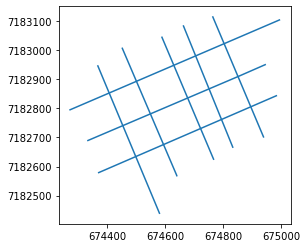

In [2]:
# reading data:

data_gdf = gpd.read_file('test1.geojson')
data_gdf.plot()

proj_epsg = data_gdf.crs

default_buffer = 5.3

default_crossing_length = default_buffer * 2

In [3]:
#finding all intersections

# intersections = []

def unary_union_from_gdf(input_gdf):
    return unary_union(input_gdf.geometry)

def find_intersections(input_gdf,return_gdf = False):

    intersections_dict = {'names':[],'geometry':[]}

    for i,line in enumerate(input_gdf.geometry):
        for j,line2 in enumerate(input_gdf.geometry):
            if not i == j:
                if line.intersects(line2):
                    intersec = line.intersection(line2)
                    intersections_dict['names'].append(f'{i}_{j}')
                    intersections_dict['geometry'].append(intersec)

    if return_gdf:
        return gpd.GeoDataFrame(intersections_dict,crs=input_gdf.crs)
    else:
        return MultiPoint(intersections_dict['geometry'])


In [38]:
intersections = find_intersections(data_gdf)

# for i,point in enumerate(intersections):
#     print(i)

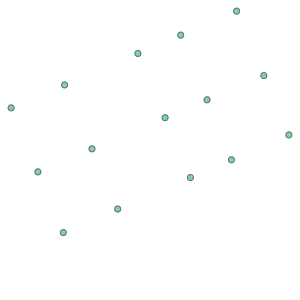

In [39]:
intersections

In [6]:
# union of lines, then spliting
all_lines = unary_union_from_gdf(data_gdf)

# polygon for difference latter:
# background_polygon = all_lines.envelope
# safe_buffer = background_polygon.length*0.25*0.1 
# background_polygon = background_polygon.buffer(safe_buffer,resolution=1,cap_style=3)

# splitted segments: 
splitted = split(all_lines,intersections)



In [7]:

def multigeom_to_gdf(inputgeom,crs,outfilepath=None):

    splitted_geoms = {
    'names' : [],
    'geometry' : []
    }

    for i,subgeom in enumerate(inputgeom):
        splitted_geoms['names'].append(f'{i}')
        splitted_geoms['geometry'].append(subgeom)

    as_gdf = gpd.GeoDataFrame(splitted_geoms,crs=crs)
    

    if outfilepath:
        as_gdf.to_file(outfilepath,driver='GeoJSON')


    return as_gdf
        


In [8]:
splitted_gdf = multigeom_to_gdf(splitted,proj_epsg,'splitted.geojson')

In [9]:
result, dangles, cuts, invalids = polygonize_full(splitted)

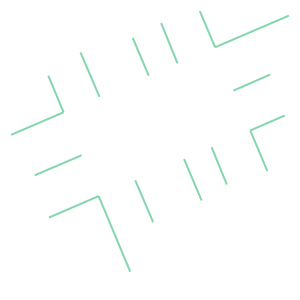

In [10]:
cuts

In [11]:
# removing cuts

# indexes_to_drop = []

for polygon in cuts:
    # line = splitted_gdf[splitted_gdf['geometry']==polygon]
    # splitted_gdf.drop(line,axis=0)
    splitted_gdf = splitted_gdf[splitted_gdf['geometry'] != polygon]

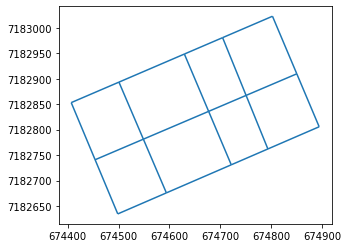

In [12]:
# the spplitted segments
splitted_gdf.plot()

In [13]:
for line in splitted_gdf.geometry:
    print(line.length)

103.1409557658569
139.4648344617507
80.04732859078092
108.32806846562215
121.7347747024017
115.44909493480438
104.1224465373435
139.00039897882894
78.43891531075504
109.85188715878009
102.10655327029312
139.9637405448447
81.78562596959013
106.68944577093235
122.58968808474067
113.64056947206929
121.99738546936199
114.85691989057982
122.36098968281021
114.06973510047487
113.0034883620398
122.85070949878235


In [14]:
proto_blocks, dangles, cuts, invalids = polygonize_full(unary_union(splitted_gdf.geometry))

In [15]:
background_polygon = unary_union(proto_blocks)

In [16]:
# sidewalk buffers

buffers = []

for line in splitted_gdf.geometry:
    buffers.append(line.buffer(default_buffer))

gdf_buffers = multigeom_to_gdf(MultiPolygon(buffers),proj_epsg,'byffers.geojson')

union_of_buffers = unary_union_from_gdf(gdf_buffers)

In [17]:
symm_diff = background_polygon.symmetric_difference(union_of_buffers)

In [18]:
multigeom_to_gdf(symm_diff,proj_epsg,'symm_diff.geojson')
multigeom_to_gdf(proto_blocks,proj_epsg,'protoblocks.geojson')

,names,geometry
0,0,"POLYGON ((674453.926 7182740.829, 674548.813 7..."
1,1,"POLYGON ((674548.813 7182781.256, 674453.926 7..."
2,2,"POLYGON ((674548.813 7182781.256, 674677.119 7..."
3,3,"POLYGON ((674677.119 7182835.921, 674548.813 7..."
4,4,"POLYGON ((674677.119 7182835.921, 674750.761 7..."
5,5,"POLYGON ((674750.761 7182867.296, 674677.119 7..."
6,6,"POLYGON ((674750.761 7182867.296, 674850.421 7..."
7,7,"POLYGON ((674850.421 7182909.756, 674750.761 7..."


In [19]:
def remove_polygons_with_holes(input_geomcontainer):

    # # also support lists
    if not isinstance(input_geomcontainer,list):
        input_geomcontainer = list(input_geomcontainer)

    # print(input_geomcontainer)

    for i,geom in enumerate(input_geomcontainer):
        if geom.geom_type == "Polygon":
            if list(geom.interiors):
                del input_geomcontainer[i]

    return input_geomcontainer



In [20]:
symm_diff2 = remove_polygons_with_holes(symm_diff)

In [21]:
rounded_blocks = []

for block in symm_diff2:
    custom_buffer = block.length * 0.01
    print(custom_buffer)
    as_buffer = block.buffer(-custom_buffer, join_style=1).buffer(custom_buffer, join_style=1)
    rounded_blocks.append(LinearRing(as_buffer.exterior.coords))

4.065789519544529
4.813867744826003
3.4379216944641207
4.024194999398523
3.9516826364484907
4.649914292062043
3.6438010324519694
4.180543317329735


In [22]:
rounded_blocks_gdf = multigeom_to_gdf(rounded_blocks,proj_epsg,'rounded.geojson')

(3, 4)
(4, 4)
(4, 4)
(4, 3)
(3, 4)
(4, 3)
(3, 4)
(4, 3)
(3, 4)
(4, 3)


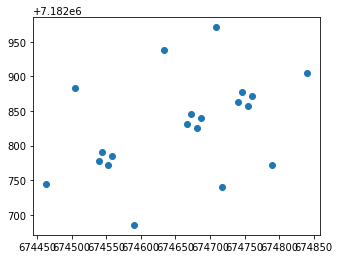

In [23]:
newlines = []
crossing_points = []


# Drawing center points of crossings

for line in splitted_gdf.geometry:
    P0 = Point(line.coords[0])
    PF = Point(line.coords[-1]) #(Point-Final)

    points_to_add = []

    number_touches_p1 = sum(splitted_gdf.intersects(P0))
    number_touches_pf = sum(splitted_gdf.intersects(PF))

    occurrences = (number_touches_p1,number_touches_pf)

    if all(x > 2 for x in occurrences):
        if any(x > 3 for x in occurrences):
            print(occurrences)
            if line.length > 2 * default_crossing_lenght:
                if number_touches_p1 > 2:
                    points_to_add.append(line.interpolate(default_crossing_lenght))

                if number_touches_pf > 2:
                    points_to_add.append(line.interpolate(-default_crossing_lenght))

            else:
                if number_touches_p1 > 2 or number_touches_pf > 2:
                    # TODO: check if midpoint is the best for short lines
                    points_to_add.append(line.interpolate(0.5,normalized=True))

    # newline = line

    if points_to_add:
        crossing_points += points_to_add

        # as_multipoint = MultiPoint(points_to_add)
        # splitted_line = split(line,as_multipoint)

        # total_points = []

        # for subline in splitted_line:
        #     total_points += list(subline.coords)

        # newline = LineString(total_points)

    # newlines.append(newline)


# newlines_gdf = multigeom_to_gdf(newlines,proj_epsg,'newlines.geojson')

crossings_gdf = multigeom_to_gdf(crossing_points,proj_epsg,'crossings.geojson')

crossings_gdf.plot()


            
        




In [24]:
# next step:
# https://stackoverflow.com/questions/57273984/fast-way-to-find-the-closest-polygon-to-a-point
# https://stackoverflow.com/questions/33311616/find-coordinate-of-the-closest-point-on-polygon-in-shapely 

distances_dict = {}

# computing distances between blocks and points

for i,point in enumerate(crossings_gdf.geometry):
    # min_poly = min(rounded_blocks_gdf.geometry,key=point.distance)

    # print(min_poly)
    # print()
    distances = []

    for j,polygon in enumerate(rounded_blocks_gdf.geometry):
        distances.append(polygon.distance(point))
        # print(distance)

    # rounded_blocks_gdf[f'dist_p{i}'] = distances
    distances_dict[i] = distances

distances_df = pd.DataFrame(distances_dict)



In [25]:
distances_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,5.300000,5.300000,18.007540,134.500158,155.659344,214.433809,235.615370,322.693084,226.855824,225.005284,225.524106,249.413349,5.300000,5.300000,18.007540,109.959337,145.220459,144.807848,146.093312,182.529055
1,98.320078,18.225383,5.300000,5.300000,18.220749,75.366313,96.430544,183.329577,86.934407,85.497357,87.505040,138.792889,5.300000,5.300000,18.225383,109.985653,5.300000,5.300000,18.220749,109.196340
2,237.446281,155.588635,134.424372,17.766119,5.300000,5.300000,17.918330,103.530685,117.750438,17.918330,5.300000,5.300000,187.479413,146.021490,144.721231,144.339228,117.358762,17.766119,5.300000,5.300000
3,317.336399,235.442458,214.260475,96.230414,75.146023,17.839099,5.300000,5.300000,117.498419,17.839099,5.300000,5.300000,254.744232,225.546400,224.588915,222.911015,146.232866,87.369024,85.186230,83.872615
4,5.300000,5.300000,17.939332,134.460134,155.620350,214.395116,235.577172,322.656243,256.564214,225.829673,224.618346,222.931143,117.036285,17.939332,5.300000,5.300000,187.965439,146.093970,144.721379,144.342586
5,98.340447,18.202493,5.300000,5.300000,18.207079,75.393088,96.460994,183.366180,148.013179,87.858075,85.196878,83.886668,117.122822,18.202493,5.300000,5.300000,117.490340,18.207079,5.300000,5.300000
6,237.495160,155.639672,134.477115,17.871109,5.300000,5.300000,17.718075,103.258423,5.300000,5.300000,17.718075,108.553651,145.218829,144.807701,146.050119,182.880496,5.300000,5.300000,17.871109,109.146000
7,317.654722,235.760973,214.578466,96.552212,75.473969,18.172407,5.300000,5.300000,5.300000,5.300000,18.172407,108.896171,226.815582,224.991523,225.829023,251.478021,86.920517,85.487456,87.752295,140.194575


In [26]:
def point_between_two(p1,p2,ratio=1/3):
    line_geom = LineString([p1,p2])

    return line_geom.interpolate(ratio,True)

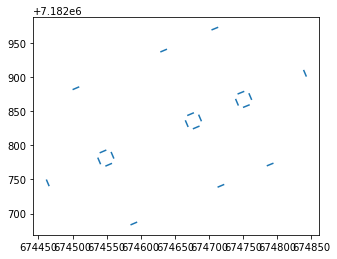

In [27]:
# rounded_blocks_gdf.iloc[0]

points_to_add_in_blocks = {}

crossing_geoms = []

# COLUMNS HOLDS POINTS
# ROWS HOLDS BLOCKS 

for column in distances_df.columns:
    crossing_geom_list = [] # to store the five points of the 

    two_smallest_block_index = list(distances_df[column].nsmallest(2).keys())

    curr_point = crossings_gdf.iloc[column].geometry

    for i in two_smallest_block_index:
        curr_block = rounded_blocks_gdf.iloc[i].geometry

        block_p,_ = nearest_points(curr_block,curr_point)


        # points to be addeded to the blocks geometry 
        if not i in points_to_add_in_blocks:
            points_to_add_in_blocks[i] = [block_p.coords]
        else:
            points_to_add_in_blocks[i].append(block_p.coords)

        # workaround for two iterations
        # generaing the crossings geometry
        if not crossing_geom_list:
            pos2_point = point_between_two(block_p,curr_point)
            crossing_geom_list = [block_p,pos2_point,curr_point]
        else:
            pos4_point = point_between_two(curr_point,block_p,2/3)
            crossing_geom_list.append(pos4_point)
            crossing_geom_list.append(block_p)

    crossing_geoms.append(LineString(crossing_geom_list))

crossings_gdf = multigeom_to_gdf(crossing_geoms,proj_epsg,'crossing_lines.geojson')
    
crossings_gdf.plot()


In [28]:
# def aggregate_points_to_linearring(lrr,point_list):
#     # future work

#     sorting_dict = {'geometry':[],'distances':[]}

#     all_points = list(lrr.coords) + point_list

#     for point in all_points:
#         curr_point = Point(point)
#         sorting_dict['points'].append(curr_point)
#         sorting_dict['distances'].append(lrr.project(curr_point))


#     as_df = pd.DataFrame(sorting_dict)
#     df2 = as_df.sort_values(by='distances')

#     # print(as_df)
#     # print(df2)
#     # print()


#     # print(dict(as_df['points']))

#     # return LinearRing(Polygon(as_df['points']).exterior.coords)  
#     return LineString(df2['points'])   
    




In [29]:
new_blocks = []

for key in points_to_add_in_blocks:
    curr_block = LineString(rounded_blocks_gdf.iloc[key].geometry)

    pts = points_to_add_in_blocks[key]

    as_coords_list = [list(pt)[0] for pt in pts]

    # print(len(as_coords_list))

    # # # method 1: trying with merges:
    # # as_multipoint = MultiPoint(as_coords_list)
    # # united = MultiLineString([as_multipoint,curr_block.coords])
    # # polygons,_,_,_ = polygonize_full(united)
    # # merged_pol = unary_union(polygons)
    # # new_block = LinearRing(merged_pol.exterior.coords)

    # #method 2: function agrregate...
    # # new_block = aggregate_points_to_linearring(curr_block,as_coords_list)

    # method 3: splitting_again
    curr_centroid = curr_block.centroid
    cs = np.array(curr_centroid)
    splitlines = []

    for point in as_coords_list:


        pt_test = np.array(point)

        vec = pt_test - cs

        p1 = cs - (10 * vec)
        p2 = cs + (10 * vec)

        splitlines.append(LineString([p1,p2]))

    splitter_geom = MultiLineString(splitlines)


    splitted = split(curr_block,splitter_geom)

    merged = LinearRing(linemerge(splitted))


    # print(split(LineString(curr_block),testline))


    #     cs = np.array(curr_centroid)

    


    # new_block = aggregate_points_to_linearring(curr_block,as_coords_list)



    # print(as_coords_list+list(curr_block.coords))

    # print()



    # print(list(curr_block.coords)+points_to_add_in_blocks[key])
    # print('\n\n')

    # # for point in points_to_add_in_blocks[key]:
    # #     split(curr_point)

    # # splitted_geom = split(LineString(curr_block),as_multipoint)






    new_blocks.append(merged)


new_blocks_gdf = multigeom_to_gdf(new_blocks,proj_epsg,'new_blocks.geojson')

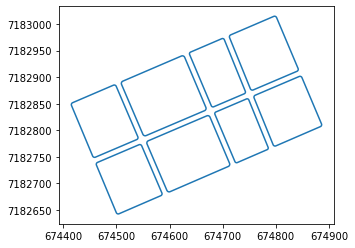

In [30]:
new_blocks_gdf.plot()